<a href="https://colab.research.google.com/github/nRknpy/lab-work/blob/main/asl_vit_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViTを用いた手話の認識
事前学習されたVisionTransformerのモデルを，手話のデータセットを用いてファインチューニングする．

# モジュールをインポート

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## データセットの準備
### ダウンロード
データセットは，ASL Fingerspelling Images（ https://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset ） を用いる．
次のコマンドでダウンロード，解凍を行う．

In [ ]:
!wget http://www.cvssp.org/FingerSpellingKinect2011/fingerspelling5.tar.bz2
!tar -jxvf fingerspelling5.tar.bz2

### Dataset，collate_fnを作成
データセットの中にはRGB画像と深度画像が含まれているが，ここでは前者のみ使う．

pytorchのImageFolderを用いてDatasetを作成するために次のようなディレクトリを作成する．

    asl
    ├── a
        ├── Acolor_0_0002.png
        ├── Acolor_0_0003.png
        ├── Acolor_0_0004.png
        ︙
    ├── b
    ├── c
    ├── d
    ├── e
    ︙

次の関数を用いてDataset用のディレクトリを作成する．

In [1]:
import os
import shutil

def prepare_asl_dataset(source, destination="asl"):
    cnt = 0
    for person in os.listdir(source):
        for label in os.listdir(source+'/'+person):
            for image in os.listdir(source+'/'+person+'/'+label):
                if image[0]=='c':
                    image_path = source+'/'+person+'/'+label+'/'+image
                    os.makedirs(destination+'/'+label, exist_ok=True)
                    shutil.copyfile(image_path, destination+'/'+label+'/'+person+image)
                    cnt += 1
    print("image count:", cnt)

source_dir = 'asl'
prepare_asl_dataset("dataset5", source_dir)

image count: 65774



モデルの事前学習で行われた画像の前処理の情報をもとに，オリジナルのデータに前処理を施す．前処理のクラスはhuggingfaceからロードできる．

In [4]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


上で作成したディレクトリから，Datasetを作成する．

In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

all_dataset = ImageFolder(root='asl')

label2id = all_dataset.class_to_idx
id2label = {label:id for id,label in label2id.items()}
label2id

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'k': 9,
 'l': 10,
 'm': 11,
 'n': 12,
 'o': 13,
 'p': 14,
 'q': 15,
 'r': 16,
 's': 17,
 't': 18,
 'u': 19,
 'v': 20,
 'w': 21,
 'x': 22,
 'y': 23}

### 前処理を定義
データに対して次のような前処理を施す．torchvisionのtransformを用いて行う．

1.   224x224にリサイズ
2.   事前学習データの平均及び分散を用いて画像を正規化

訓練用データセットには，加えてランダムな左右反転を施す（左右両方の手を学習させるため）．

In [5]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(tuple(feature_extractor.size.values())),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(tuple(feature_extractor.size.values())),
            CenterCrop(tuple(feature_extractor.size.values())),
            ToTensor(),
            normalize,
        ]
    )

In [6]:
from torch.utils.data import Dataset

# random_splitを用いてデータセットをtrain,val,testに分割すると別々のtransformを割り当てられないため，
# 自作のSubsetを定義してtransformを後から割り当てる．
class SetTransform(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform
  
  def __getitem__(self, idx):
    img, label = self.dataset[idx]
    if self.transform:
      img = self.transform(img)
    return img, label
  
  def __len__(self):
    return len(self.dataset)

データセットをtrain,validation,test用に分割し，各々にtransformを割り当てる．

ここでは，val,test用のデータをそれぞれ1000個ずつとし，残りを訓練に使う．

In [7]:
val_size = 1000
test_size = 1000
train_size = len(all_dataset) - val_size - test_size

test_dataset, trainval_dataset = torch.utils.data.random_split(all_dataset, [test_size, train_size + val_size])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_dataset = SetTransform(train_dataset, _train_transforms)
val_dataset = SetTransform(val_dataset, _val_transforms)
test_dataset = SetTransform(test_dataset, _val_transforms)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))
print('test:', len(test_dataset))

train: 63774
validation: 1000
test: 1000


バッチを`pixel_values`と`labels`をキーに持つ辞書にする，collate_fnを作成する．これは，Trainer内でモデルに入力する際にアンパックするためである．

In [8]:
def collate_fn(examples):
    imgs, labels = zip(*examples)
    pixel_values = torch.stack(imgs)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

挙動確認．バッチが辞書型になって返される．

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## モデルの定義
huggingfaceから，事前学習されたViTのモデルをロードする．

In [14]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label2id),
                                                  label2id=label2id,
                                                  id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainingArgumentsを設定する．詳細は以下の通り．

* モデルのチェックポイント，パラメータを`asl-vit`ディレクトリに保存
* 1エポックごとにチェックポイントを保存
* 1エポックごとに評価
* 学習率=$2.0×10^{-5}$
* 訓練データのバッチサイズ=10
* valデータのバッチサイズ=4
* 3エポック分訓練を回す
* 重み減衰=0.01
* 学習中に得られたベストなモデルを学習後にロードする


In [11]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"asl-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

評価基準（ここでは正解率）を定義

In [13]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_263934/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Trainerを定義．

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

## 訓練

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 63774
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 19134
  Number of trainable parameters = 85817112
  3%|▎         | 500/19134 [02:53<1:43:50,  2.99it/s]

{'loss': 2.6987, 'learning_rate': 1.947737012647643e-05, 'epoch': 0.08}


  5%|▌         | 1000/19134 [05:39<2:50:12,  1.78it/s]

{'loss': 1.8825, 'learning_rate': 1.895474025295286e-05, 'epoch': 0.16}


  8%|▊         | 1500/19134 [08:27<1:38:48,  2.97it/s]

{'loss': 1.3638, 'learning_rate': 1.843211037942929e-05, 'epoch': 0.24}


 10%|█         | 2000/19134 [11:25<1:31:01,  3.14it/s]

{'loss': 1.0346, 'learning_rate': 1.790948050590572e-05, 'epoch': 0.31}


 13%|█▎        | 2500/19134 [14:26<1:28:16,  3.14it/s]

{'loss': 0.8563, 'learning_rate': 1.7386850632382148e-05, 'epoch': 0.39}


 16%|█▌        | 3000/19134 [17:45<2:06:08,  2.13it/s]

{'loss': 0.6886, 'learning_rate': 1.6864220758858578e-05, 'epoch': 0.47}


 18%|█▊        | 3500/19134 [21:02<1:22:06,  3.17it/s]

{'loss': 0.6067, 'learning_rate': 1.6341590885335007e-05, 'epoch': 0.55}


 21%|██        | 4000/19134 [24:34<1:18:43,  3.20it/s]

{'loss': 0.5285, 'learning_rate': 1.5818961011811436e-05, 'epoch': 0.63}


 24%|██▎       | 4500/19134 [27:49<1:32:23,  2.64it/s]

{'loss': 0.4598, 'learning_rate': 1.5296331138287865e-05, 'epoch': 0.71}


 26%|██▌       | 5000/19134 [31:09<1:08:55,  3.42it/s]

{'loss': 0.4529, 'learning_rate': 1.4773701264764295e-05, 'epoch': 0.78}


 29%|██▊       | 5500/19134 [34:30<1:13:27,  3.09it/s]

{'loss': 0.4121, 'learning_rate': 1.4251071391240726e-05, 'epoch': 0.86}


 31%|███▏      | 6000/19134 [37:47<3:05:29,  1.18it/s]

{'loss': 0.369, 'learning_rate': 1.3728441517717155e-05, 'epoch': 0.94}


 33%|███▎      | 6378/19134 [40:13<56:52,  3.74it/s]  ***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                    
 33%|███▎      | 6378/19134 [40:43<56:52,  3.74it/s]Saving model checkpoint to asl-vit/checkpoint-6378
Configuration saved in asl-vit/checkpoint-6378/config.json


{'eval_loss': 0.08873815834522247, 'eval_accuracy': 0.983, 'eval_runtime': 29.6106, 'eval_samples_per_second': 33.772, 'eval_steps_per_second': 8.443, 'epoch': 1.0}


Model weights saved in asl-vit/checkpoint-6378/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-6378/preprocessor_config.json
 34%|███▍      | 6501/19134 [41:07<30:38,  6.87it/s]   

{'loss': 0.3753, 'learning_rate': 1.3205811644193583e-05, 'epoch': 1.02}


 37%|███▋      | 7001/19134 [42:19<26:51,  7.53it/s]  

{'loss': 0.3345, 'learning_rate': 1.2683181770670012e-05, 'epoch': 1.1}


 39%|███▉      | 7501/19134 [43:29<27:50,  6.96it/s]

{'loss': 0.3235, 'learning_rate': 1.2160551897146441e-05, 'epoch': 1.18}


 42%|████▏     | 8001/19134 [44:40<26:08,  7.10it/s]  

{'loss': 0.3206, 'learning_rate': 1.1637922023622872e-05, 'epoch': 1.25}


 44%|████▍     | 8501/19134 [45:50<27:07,  6.53it/s]  

{'loss': 0.2981, 'learning_rate': 1.1115292150099302e-05, 'epoch': 1.33}


 47%|████▋     | 9001/19134 [47:01<22:17,  7.57it/s]  

{'loss': 0.3083, 'learning_rate': 1.059266227657573e-05, 'epoch': 1.41}


 50%|████▉     | 9501/19134 [48:14<25:54,  6.20it/s]  

{'loss': 0.2813, 'learning_rate': 1.0070032403052159e-05, 'epoch': 1.49}


 52%|█████▏    | 10001/19134 [49:24<21:03,  7.23it/s]

{'loss': 0.2979, 'learning_rate': 9.547402529528588e-06, 'epoch': 1.57}


 55%|█████▍    | 10501/19134 [50:34<21:06,  6.82it/s]

{'loss': 0.2769, 'learning_rate': 9.024772656005017e-06, 'epoch': 1.65}


 57%|█████▋    | 11001/19134 [51:43<19:02,  7.12it/s]

{'loss': 0.2504, 'learning_rate': 8.502142782481447e-06, 'epoch': 1.72}


 60%|██████    | 11501/19134 [52:53<17:16,  7.36it/s]

{'loss': 0.2612, 'learning_rate': 7.979512908957878e-06, 'epoch': 1.8}


 63%|██████▎   | 12001/19134 [54:03<15:26,  7.70it/s]

{'loss': 0.2658, 'learning_rate': 7.456883035434306e-06, 'epoch': 1.88}


 65%|██████▌   | 12501/19134 [55:13<14:36,  7.57it/s]

{'loss': 0.2619, 'learning_rate': 6.934253161910735e-06, 'epoch': 1.96}


 67%|██████▋   | 12755/19134 [55:50<13:55,  7.63it/s]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                     
 67%|██████▋   | 12756/19134 [55:54<13:55,  7.63it/s]Saving model checkpoint to asl-vit/checkpoint-12756
Configuration saved in asl-vit/checkpoint-12756/config.json


{'eval_loss': 0.03231218829751015, 'eval_accuracy': 0.992, 'eval_runtime': 4.5329, 'eval_samples_per_second': 220.609, 'eval_steps_per_second': 55.152, 'epoch': 2.0}


Model weights saved in asl-vit/checkpoint-12756/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-12756/preprocessor_config.json
 68%|██████▊   | 13001/19134 [56:24<12:17,  8.31it/s]  

{'loss': 0.242, 'learning_rate': 6.411623288387165e-06, 'epoch': 2.04}


 71%|███████   | 13501/19134 [57:24<11:19,  8.29it/s]

{'loss': 0.2285, 'learning_rate': 5.888993414863594e-06, 'epoch': 2.12}


 73%|███████▎  | 14001/19134 [58:25<10:18,  8.30it/s]

{'loss': 0.239, 'learning_rate': 5.366363541340024e-06, 'epoch': 2.2}


 76%|███████▌  | 14501/19134 [59:26<09:20,  8.26it/s]

{'loss': 0.2369, 'learning_rate': 4.843733667816453e-06, 'epoch': 2.27}


 78%|███████▊  | 15001/19134 [1:00:28<08:24,  8.19it/s]

{'loss': 0.2288, 'learning_rate': 4.321103794292882e-06, 'epoch': 2.35}


 81%|████████  | 15501/19134 [1:01:31<13:13,  4.58it/s]

{'loss': 0.1968, 'learning_rate': 3.7984739207693117e-06, 'epoch': 2.43}


 84%|████████▎ | 16001/19134 [1:02:35<07:26,  7.02it/s]

{'loss': 0.2254, 'learning_rate': 3.275844047245741e-06, 'epoch': 2.51}


 86%|████████▌ | 16501/19134 [1:03:43<05:22,  8.18it/s]

{'loss': 0.2276, 'learning_rate': 2.7532141737221704e-06, 'epoch': 2.59}


 89%|████████▉ | 17001/19134 [1:04:53<05:27,  6.52it/s]

{'loss': 0.2077, 'learning_rate': 2.2305843001985997e-06, 'epoch': 2.67}


 91%|█████████▏| 17501/19134 [1:06:03<03:34,  7.61it/s]

{'loss': 0.1985, 'learning_rate': 1.707954426675029e-06, 'epoch': 2.74}


 94%|█████████▍| 18001/19134 [1:07:14<02:27,  7.69it/s]

{'loss': 0.201, 'learning_rate': 1.185324553151458e-06, 'epoch': 2.82}


 97%|█████████▋| 18501/19134 [1:08:22<01:22,  7.65it/s]

{'loss': 0.1831, 'learning_rate': 6.626946796278875e-07, 'epoch': 2.9}


 99%|█████████▉| 19001/19134 [1:09:26<00:16,  7.83it/s]

{'loss': 0.1969, 'learning_rate': 1.4006480610431694e-07, 'epoch': 2.98}


100%|█████████▉| 19133/19134 [1:09:44<00:00,  8.15it/s]***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
                                                       
100%|██████████| 19134/19134 [1:09:49<00:00,  8.15it/s]Saving model checkpoint to asl-vit/checkpoint-19134
Configuration saved in asl-vit/checkpoint-19134/config.json


{'eval_loss': 0.013479172252118587, 'eval_accuracy': 0.998, 'eval_runtime': 4.5862, 'eval_samples_per_second': 218.047, 'eval_steps_per_second': 54.512, 'epoch': 3.0}


Model weights saved in asl-vit/checkpoint-19134/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-19134/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from asl-vit/checkpoint-19134 (score: 0.998).
100%|██████████| 19134/19134 [1:09:50<00:00,  4.57it/s]

{'train_runtime': 4190.5228, 'train_samples_per_second': 45.656, 'train_steps_per_second': 4.566, 'train_loss': 0.47205575087906065, 'epoch': 3.0}


TrainOutput(global_step=19134, training_loss=0.47205575087906065, metrics={'train_runtime': 4190.5228, 'train_samples_per_second': 45.656, 'train_steps_per_second': 4.566, 'train_loss': 0.47205575087906065, 'epoch': 3.0})

In [45]:
trainer.save_state()
trainer.save_model()

Saving model checkpoint to asl-vit
Configuration saved in asl-vit/config.json
Model weights saved in asl-vit/pytorch_model.bin
Image processor saved in asl-vit/preprocessor_config.json


## 評価
ファインチューニングしたモデルの性能を評価する．

テストデータをモデルに入力し，推定ラベルを得る．

In [15]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 4
100%|██████████| 250/250 [00:25<00:00,  9.63it/s]


テストデータに対する損失，正解率等を計算．

In [16]:
print(outputs.metrics)

{'test_loss': 0.016631782054901123, 'test_accuracy': 0.998, 'test_runtime': 26.3446, 'test_samples_per_second': 37.958, 'test_steps_per_second': 9.49}


混同行列を作成．

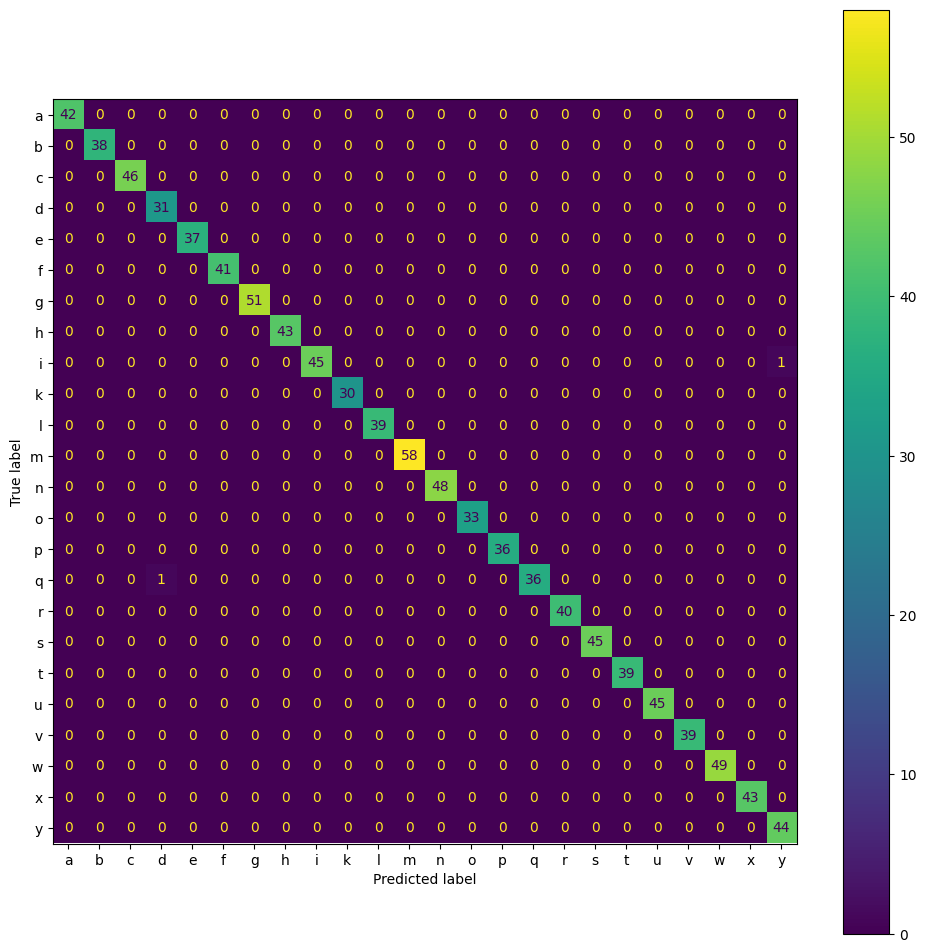

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

## 内部表現の比較

### fine-tuning前

In [10]:
from transformers import ViTForImageClassification

non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=len(label2id),
                                                                label2id=label2id,
                                                                id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


torch.Size([1000, 768])
(1000, 2)
(1000,)


/tmp/ipykernel_13180/3321905619.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mp = ax.scatter(x[0], x[1],


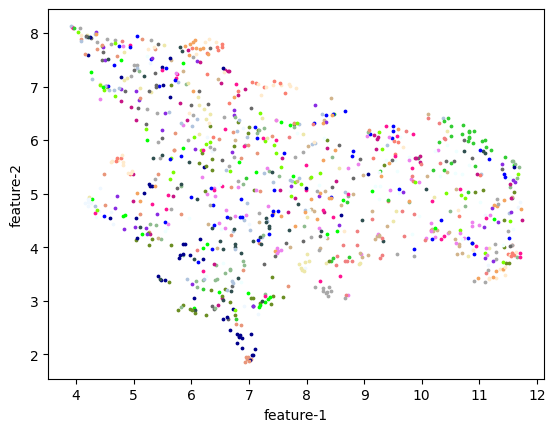

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random

def choose_colors(num_colors):
    tmp = list(colors.CSS4_COLORS.values())
    random.shuffle(tmp)
    label2color = tmp[:num_colors]
    return label2color

def plot_tokens(tokens, labels, label2color):
    # tsne = TSNE(n_components=2)
    # zs = tsne.fit_transform(tokens.numpy())
    umap = UMAP()
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        c=label2color[y],
                        s=3,
                        cmap="jet")
    plt.show()

label2color = choose_colors(len(label2id))

tokens, labels = CLE_tokens(non_finetuned_model.to(device),
                            feature_extractor,
                            test_dataset,
                            device)
print(tokens.shape)
plot_tokens(tokens, labels, label2color)

### fine-tuning後

In [14]:
finetuned_model = ViTForImageClassification.from_pretrained('asl-vit/',
                                                            num_labels=len(label2id),
                                                            label2id=label2id,
                                                            id2label=id2label).to(device)

100%|██████████| 1000/1000 [01:04<00:00, 15.47it/s]


(1000, 2)
(1000,)


/tmp/ipykernel_13180/3321905619.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mp = ax.scatter(x[0], x[1],


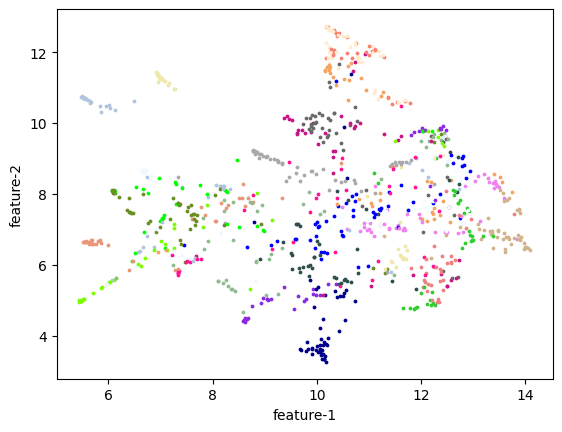

In [15]:
tokens, labels = CLE_tokens(finetuned_model,
                            feature_extractor,
                            test_dataset,
                            device)
plot_tokens(tokens, labels, label2color)